<a href="https://colab.research.google.com/github/mojojojoe/Auto_DCF-with-2d-3d-heatmap-and-montecarlo-simulation/blob/main/Automated_DCF_and_sensitivity_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Automated DCF Valuation Tool (Original Implementation) ---
import requests
import pandas as pd
import numpy as np
from fredapi import Fred
import yfinance as yf

# --- Configuration ---
FMP_API_KEY = 'gUCO9waKiArsoKXiAzC2aiZtNsU0JmUb'
FRED_API_KEY = 'your_api_key'
TICKER = 'AAPL'
FORECAST_YEARS = 5
ERP_FILE = r'file path'

# --- Data Retrieval Utilities ---

def fetch_financials(symbol, statement, api_key, freq='annual'):
    """
    Retrieve financial statements from Financial Modeling Prep API.
    """
    endpoint = f"https://financialmodelingprep.com/api/v3/{statement}/{symbol}?period={freq}&apikey={FMP_API_KEY}"
    data = requests.get(endpoint).json()
    return pd.DataFrame(data) if isinstance(data, list) else pd.DataFrame([data])

def get_risk_free_rate(api_key, series='DGS10'):
    """
    Get the latest US 10Y Treasury yield from FRED.
    """
    fred = Fred(api_key=api_key)
    rates = fred.get_series(series)
    return float(rates.iloc[-1]) / 100

def get_country_and_beta(symbol, api_key):
    """
    Retrieve beta and country for a given ticker.
    """
    profile = requests.get(f"https://financialmodelingprep.com/api/v3/profile/{symbol}?apikey={api_key}").json()
    beta = float(profile[0]['beta'])
    country = yf.Ticker(symbol).info.get('country', 'United States')
    return beta, country

def get_equity_risk_premium(country, excel_path):
    """
    Lookup the equity risk premium for a given country from Excel.
    """
    df = pd.read_excel(excel_path)
    return float(df.loc[df['Row Labels'] == country, 'Average of Equity Risk Premium'].values[0])

# --- DCF Model Class ---

class DiscountedCashFlowModel:
    """
    Discounted Cash Flow (DCF) valuation model for public companies.
    """
    def __init__(self, ticker, years, fmp_key, fred_key, erp_path):
        self.ticker = ticker
        self.years = years
        self.fmp_key = fmp_key
        self.fred_key = fred_key
        self.erp_path = erp_path
        self._load_data()
        self._prepare_parameters()

    def _load_data(self):
        self.inc = fetch_financials(self.ticker, 'income-statement', self.fmp_key)
        self.bs = fetch_financials(self.ticker, 'balance-sheet-statement', self.fmp_key)
        self.cf = fetch_financials(self.ticker, 'cash-flow-statement', self.fmp_key)
        self.ratios = fetch_financials(self.ticker, 'ratios', self.fmp_key)

    def _prepare_parameters(self):
        self.risk_free = get_risk_free_rate(self.fred_key)
        self.beta, self.country = get_country_and_beta(self.ticker, self.fmp_key)
        self.erp = get_equity_risk_premium(self.country, self.erp_path)
        self.tax_rate = float(self.ratios['effectiveTaxRate'][0])
        self.debt = float(self.bs['totalDebt'][0])
        self.equity = float(self.bs['totalStockholdersEquity'][0])
        self.cash = float(self.bs['cashAndCashEquivalents'][0])
        self.shares = float(self.inc['weightedAverageShsOutDil'][0])

    def _interest_coverage(self):
        ebit = float(self.inc['ebitda'][0]) - float(self.inc['depreciationAndAmortization'][0])
        interest = float(self.inc['interestExpense'][0])
        return ebit / interest if interest else 10.0

    def _credit_spread(self, coverage):
        # Standard mapping based on coverage ratio
        if coverage > 8.5: return 0.0063
        if coverage > 6.5: return 0.0078
        if coverage > 5.5: return 0.0098
        if coverage > 4.25: return 0.0108
        if coverage > 3: return 0.0122
        if coverage > 2.5: return 0.0156
        if coverage > 2: return 0.0240
        return 0.0515 #If the coverage ratio is not greater than 2 (i.e., it is 2 or less), the company is
                      #considered high risk, so the highest spread (0.0515, or 5.15%) is used.

    def _cost_of_debt(self):
        coverage = self._interest_coverage()
        return self.risk_free + self._credit_spread(coverage)

    def _cost_of_equity(self):
        return self.risk_free + self.beta * self.erp

    def _wacc(self):
        kd = self._cost_of_debt()
        ke = self._cost_of_equity()
        d = self.debt
        e = self.equity
        total = d + e
        return (kd * (1 - self.tax_rate) * d / total) + (ke * e / total)



    def beta_for_target_wacc(model, target_wacc, tol=1e-4, max_iter=50):
        """
        Binary search for beta such that model._wacc() ≈ target_wacc.
        Returns the beta value.
        """
        orig_beta = model.beta
        low, high = 0.01, 5.0
        for _ in range(max_iter):
            mid = (low + high) / 2
            model.beta = mid
            wacc = model._wacc()
            if abs(wacc - target_wacc) < tol:
                model.beta = orig_beta
                return mid
            if wacc < target_wacc:
                low = mid
            else:
                high = mid
        model.beta = orig_beta
        return mid


    def run_dcf(self, ebit_growth=0.05, capex_growth=0.03, perp_growth=0.025,depr_growth=0.02,wc_growth=0.02):
        """
        Run the DCF calculation and print results.
        """
        wacc = self._wacc()
        ebit = float(self.inc['ebitda'][0]) - float(self.inc['depreciationAndAmortization'][0])
        depr = float(self.cf['depreciationAndAmortization'][0])
        wc = float(self.cf['changeInWorkingCapital'][0])
        capex = float(self.cf['capitalExpenditure'][0])
        fcf = ebit * (1 - self.tax_rate) + depr +wc + capex
        npv_fcf = [fcf]
        for yr in range(1, self.years + 1):
            ebit *= (1 + ebit_growth)
            depr *= (1 + depr_growth)
            capex *= (1 + capex_growth)
            wc *= (1 + wc_growth)
            fcf = ebit * (1 - self.tax_rate) + depr + wc + capex
            npv = fcf / ((1 + wacc) ** yr)
            npv_fcf.append(npv)
        terminal_fcf = npv_fcf[-1] * (1 + perp_growth)
        terminal_value = terminal_fcf / (wacc - perp_growth)
        npv_terminal = terminal_value / ((1 + wacc) ** (self.years + 1))
        enterprise_value = sum(npv_fcf) + npv_terminal
        equity_value = enterprise_value - self.debt + self.cash
        share_price = equity_value / self.shares
        print(f"WACC: {wacc:.4f}")
        print(f"Enterprise Value: {enterprise_value:.2f}")
        print(f"Equity Value: {equity_value:.2f}")
        print(f"Implied Share Price: {share_price:.2f}")
        self.share_price = share_price

    def compare_to_market_targets(self):
        """
        Compare model price to Yahoo Finance and FMP consensus targets.
        """
        yf_target = yf.Ticker(self.ticker).info.get('targetMeanPrice', np.nan)
        fmp_resp = requests.get(
            f"https://financialmodelingprep.com/api/v3/price-target/{self.ticker}?apikey={self.fmp_key}"
        ).json()
        fmp_target = float(fmp_resp[0].get('priceTargetMean', np.nan)) if fmp_resp else np.nan
        model_price = getattr(self, 'share_price', None)
        if model_price is None:
            print("Run DCF first.")
            return
        if not np.isnan(yf_target):
            spread = (model_price - yf_target) / yf_target * 100
            print(f"Yahoo Finance Target: {yf_target:.2f} | Spread: {spread:.1f}%")
        else:
            print("No Yahoo Finance consensus target available.")
        if not np.isnan(fmp_target):
            spread = (model_price - fmp_target) / fmp_target * 100
            print(f"FMP Target: {fmp_target:.2f} | Spread: {spread:.1f}%")
        else:
            print("No FMP consensus target available.")



In [ ]:
def print_dcf_calculation_details(model, earnings_growth=0.05, capex_growth=0.03, perp_growth=0.025):
    """
    Print detailed formulas and numbers for Ke, Kd, CAPM, WACC, discount rate, and FCF.
    """
    # Gather inputs
    rf = model.risk_free
    beta = model.beta
    erp = model.erp
    tax = model.tax_rate
    debt = model.debt
    equity = model.equity
    total = debt + equity
    cash = model.cash
    shares = model.shares
    total = debt + equity

    # Cost of Debt (Kd)
    coverage = model._interest_coverage()
    credit_spread = model._credit_spread(coverage)
    kd = rf + credit_spread

    # Cost of Equity (Ke, CAPM)
    ke = rf + beta * erp

    # WACC
    wacc = (kd * (1 - tax) * debt / total) + (ke * equity / total)

    # FCF calculation (first year)
    ebit = float(model.inc['ebitda'][0]) - float(model.inc['depreciationAndAmortization'][0])
    depr = float(model.cf['depreciationAndAmortization'][0])
    wc = float(model.cf['changeInWorkingCapital'][0])
    capex = float(model.cf['capitalExpenditure'][0])
    fcf = ebit * (1 - tax) + depr + wc + capex

     # Terminal value and DCF (single period for illustration)
    terminal_fcf = fcf * (1 + perp_growth)
    terminal_value = terminal_fcf / (wacc - perp_growth)
    npv_terminal = terminal_value / (1 + wacc)
    npv_fcf = fcf / (1 + wacc)
    enterprise_value = npv_fcf + npv_terminal
    equity_value = enterprise_value - debt + cash
    share_price = equity_value / shares

    print("==== DCF Calculation Details ====")
    print(f"Risk-free rate (rf): {rf:.4f}")
    print(f"Beta: {beta:.4f}")
    print(f"Equity Risk Premium (ERP): {erp:.4f}")
    print(f"Tax Rate: {tax:.4f}")
    print(f"Total Debt: {debt:.2f}")
    print(f"Total Equity: {equity:.2f}")
    print(f"Interest Coverage Ratio: {coverage:.4f}")
    print(f"Credit Spread: {credit_spread:.4f}")

    print("\nCost of Debt (Kd):")
    print(f"Kd = rf + credit_spread = {rf:.4f} + {credit_spread:.4f} = {kd:.4f}")

    print("\nCost of Equity (Ke, CAPM):")
    print(f"Ke = rf + beta * ERP = {rf:.4f} + {beta:.4f} * {erp:.4f} = {ke:.4f}")

    print("\nWACC:")
    print(f"WACC = (Kd * (1 - tax) * D / (D+E)) + (Ke * E / (D+E))")
    print(f"     = ({kd:.4f} * (1 - {tax:.4f}) * {debt:.2f} / {total:.2f}) + ({ke:.4f} * {equity:.2f} / {total:.2f})")
    print(f"     = {wacc:.4f}")

    print("\nDiscount Rate for FCFs: WACC = {:.4f}".format(wacc))

    print("\nFirst Year Free Cash Flow (FCF):")
    print(f"FCF = EBIT * (1 - tax) + Depreciation - Change in WC - CapEx")
    print(f"    = {ebit:.2f} * (1 - {tax:.4f}) + {depr:.2f} - {wc:.2f} - {capex:.2f}")
    print(f"    = {ebit * (1 - tax):.2f} + {depr:.2f} - {wc:.2f} - {capex:.2f}")
    print(f"    = {fcf:.2f}")

    print("\nTerminal Value Calculation:")
    print(f"Terminal FCF = FCF * (1 + g) = {fcf:.2f} * (1 + {perp_growth:.4f}) = {terminal_fcf:.2f}")
    print(f"Terminal Value = Terminal FCF / (WACC - g) = {terminal_fcf:.2f} / ({wacc:.4f} - {perp_growth:.4f}) = {terminal_value:.2f}")
    print(f"NPV of Terminal Value = {terminal_value:.2f} / (1 + {wacc:.4f}) = {npv_terminal:.2f}")

    print("\nEnterprise Value (EV):")
    print(f"EV = NPV(FCF) + NPV(Terminal Value) = {npv_fcf:.2f} + {npv_terminal:.2f} = {enterprise_value:.2f}")

    print("\nEquity Value:")
    print(f"Equity Value = EV - Debt + Cash = {enterprise_value:.2f} - {debt:.2f} + {cash:.2f} = {equity_value:.2f}")

    print("\nImplied Share Price:")
    print(f"Share Price = Equity Value / Shares Outstanding = {equity_value:.2f} / {shares:.2f} = {share_price:.2f}")



# Usage example:
print_dcf_calculation_details(dcf_model)

==== DCF Calculation Details ====
Risk-free rate (rf): 0.0446
Beta: 1.2110
Equity Risk Premium (ERP): 0.0433
Tax Rate: 0.2409
Total Debt: 119059000000.00
Total Equity: 56950000000.00
Interest Coverage Ratio: 10.0000
Credit Spread: 0.0063

Cost of Debt (Kd):
Kd = rf + credit_spread = 0.0446 + 0.0063 = 0.0509

Cost of Equity (Ke, CAPM):
Ke = rf + beta * ERP = 0.0446 + 1.2110 * 0.0433 = 0.0970

WACC:
WACC = (Kd * (1 - tax) * D / (D+E)) + (Ke * E / (D+E))
     = (0.0509 * (1 - 0.2409) * 119059000000.00 / 176009000000.00) + (0.0970 * 56950000000.00 / 176009000000.00)
     = 0.0575

Discount Rate for FCFs: WACC = 0.0575

First Year Free Cash Flow (FCF):
FCF = EBIT * (1 - tax) + Depreciation - Change in WC - CapEx
    = 123216000000.00 * (1 - 0.2409) + 11445000000.00 - 3651000000.00 - -9447000000.00
    = 93531805288.09 + 11445000000.00 - 3651000000.00 - -9447000000.00
    = 99180805288.09

Terminal Value Calculation:
Terminal FCF = FCF * (1 + g) = 99180805288.09 * (1 + 0.0250) = 101660325420

In [ ]:
# --- Example Usage ---
dcf_model = DiscountedCashFlowModel(
    ticker=TICKER,
    years=FORECAST_YEARS,
    fmp_key=FMP_API_KEY,
    fred_key=FRED_API_KEY,
    erp_path=ERP_FILE
)

#adjust estimates according to your research and company of choice

dcf_model.run_dcf(ebit_growth=0.06,
                  capex_growth=0.03,
                  perp_growth=0.03,
                  depr_growth=0.02,
                  wc_growth=0.02
)

dcf_model.compare_to_market_targets()

WACC: 0.0575
Enterprise Value: 3240485200855.62
Equity Value: 3151369200855.62
Implied Share Price: 204.53
Yahoo Finance Target: 228.85 | Spread: -10.6%
No FMP consensus target available.


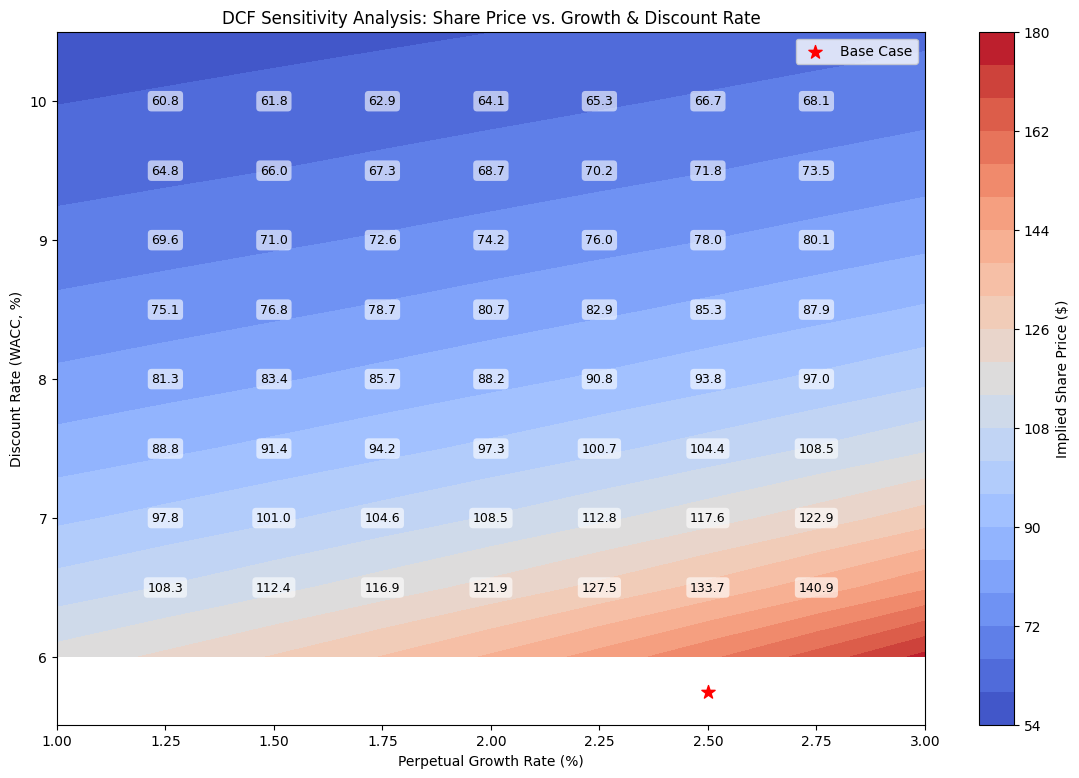

Sensitivity Table (Share Price):
             1.00%       1.25%       1.50%       1.75%       2.00%  \
6.00%   116.486170  121.179957  126.394161  132.220413  138.773197   
6.50%   104.612806  108.311903  112.380821  116.877939  121.874603   
7.00%    94.817735   97.783008  101.018206  104.561943  108.460567   
7.50%    86.411370   88.809294   91.407112   94.230907   97.311504   
8.00%    79.319644   81.283838   83.399049   85.683391   88.157993   
8.50%    73.421991   75.056874   76.808622   78.690230   80.716694   
9.00%    68.191472   69.558265   71.016178   72.574636   74.244414   
9.50%    63.649332   64.801715   66.026076   67.329375   68.719501   
10.00%   59.775967   60.759126   61.800141   62.904271   64.077438   
10.50%   56.263495   57.104129   57.991455   58.929473   59.922657   

             2.25%       2.50%       2.75%       3.00%  
6.00%   146.197446  154.679390  164.462390  175.870670  
6.50%   127.458944  133.741118  140.860647  148.996903  
7.00%   112.770200  117.5

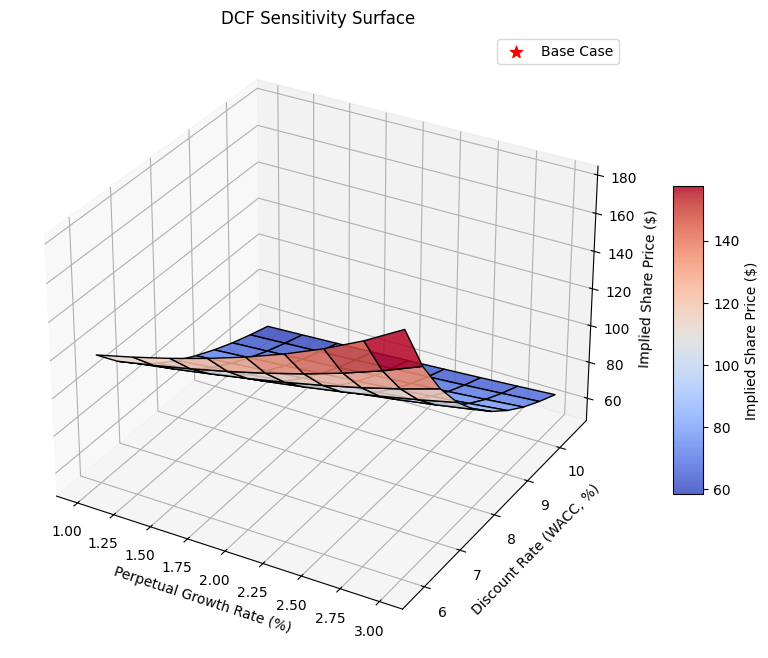

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401, needed for 3D plot
import matplotlib.ticker as mticker

def dcf_sensitivity_analysis(
    model,
    earnings_growth=0.05,
    capex_growth=0.03,
    perp_growth_range=(0.01, 0.03, 0.0025),  # 1.0% to 3.0% in 0.25% steps
    discount_rate_range=(0.06, 0.10, 0.005)  # 6.0% to 10.0% in 0.5% steps
):
    perp_growths = np.arange(perp_growth_range[0], perp_growth_range[1] + perp_growth_range[2], perp_growth_range[2])
    discount_rates = np.arange(discount_rate_range[0], discount_rate_range[1] + discount_rate_range[2], discount_rate_range[2])
    results = np.zeros((len(discount_rates), len(perp_growths)))
    orig_beta = model.beta

    # Calculate results grid
    for i, dr in enumerate(discount_rates):
        for j, g in enumerate(perp_growths):
            # --- Modified: Use beta_for_target_wacc to set beta for target WACC ---
            beta_s = model.beta_for_target_wacc( dr)
            model.beta = beta_s
            wacc = model._wacc()
            ebit = float(model.inc['ebitda'][0]) - float(model.inc['depreciationAndAmortization'][0])
            depr = float(model.cf['depreciationAndAmortization'][0])
            wc = float(model.cf['changeInWorkingCapital'][0])
            capex = float(model.cf['capitalExpenditure'][0])
            fcf = ebit * (1 - model.tax_rate) + depr + wc + capex
            npv_fcf = [fcf]
            for yr in range(1, model.years + 1):
                ebit *= (1 + earnings_growth)
                depr *= (1 + earnings_growth)
                capex *= (1 + capex_growth)
                wc *= 0.7
                fcf = ebit * (1 - model.tax_rate) + depr + wc + capex
                npv = fcf / ((1 + wacc) ** yr)
                npv_fcf.append(npv)
            terminal_fcf = npv_fcf[-1] * (1 + g)
            terminal_value = terminal_fcf / (wacc - g)
            npv_terminal = terminal_value / ((1 + wacc) ** (model.years + 1))
            enterprise_value = sum(npv_fcf) + npv_terminal
            equity_value = enterprise_value - model.debt + model.cash
            share_price = equity_value / model.shares
            results[i, j] = share_price
            # --- Reset beta after each cell ---
            model.beta = orig_beta



    # 1. Heatmap (2D) with annotations and base case marker
    plt.figure(figsize=(14, 9))
    X, Y = np.meshgrid(perp_growths * 100, discount_rates * 100)
    cp = plt.contourf(X, Y, results, cmap='coolwarm', levels=20)
    plt.colorbar(cp, label='Implied Share Price ($)')
    plt.xlabel('Perpetual Growth Rate (%)')
    plt.ylabel('Discount Rate (WACC, %)')
    plt.title('DCF Sensitivity Analysis: Share Price vs. Growth & Discount Rate')


    # Annotate values for clarity with better alignment
       # Annotate selectively with background boxes to improve readability
    for i in range(len(discount_rates)):
        for j in range(len(perp_growths)):
            if (1 <= i <= len(discount_rates)-2) and (1 <= j <= len(perp_growths)-2):  # middle zones only
                price = results[i, j]
                plt.text(
                    perp_growths[j]*100,
                    discount_rates[i]*100,
                    f"{price:.1f}",
                    ha='center', va='center',
                    fontsize=9, color='black',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.6)
                )


    # Mark the base case (default model WACC and perp growth)
    base_wacc = round(model._wacc(), 4)
    base_g = 0.025
    plt.scatter([base_g*100], [base_wacc*100], color='red', s=100, marker='*', label='Base Case')
    plt.legend()

    plt.show()

    # 2. 3D Surface Plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    X3D, Y3D = np.meshgrid(perp_growths * 100, discount_rates * 100)
    surf = ax.plot_surface(X3D, Y3D, results, cmap='coolwarm', edgecolor='k', alpha=0.85)
    ax.set_xlabel('Perpetual Growth Rate (%)')
    ax.set_ylabel('Discount Rate (WACC, %)')
    ax.set_zlabel('Implied Share Price ($)')
    ax.set_title('DCF Sensitivity Surface')
    fig.colorbar(surf, shrink=0.5, aspect=10, label='Implied Share Price ($)')

    # Mark the base case
    ax.scatter(base_g*100, base_wacc*100,
               results[(np.abs(discount_rates-base_wacc)).argmin(), (np.abs(perp_growths-base_g)).argmin()],
               color='red', s=80, marker='*', label='Base Case')
    ax.legend()

    # Optional: print the results as a DataFrame
    df = pd.DataFrame(results, index=[f"{x*100:.2f}%" for x in discount_rates], columns=[f"{y*100:.2f}%" for y in perp_growths])
    print("Sensitivity Table (Share Price):")
    print(df)

# Usage example (after running your DCF model):
dcf_sensitivity_analysis(dcf_model)

# Monte Carlo simulation

| Variable                        | Suggested Distribution | Parameters                                 | Why It Makes Sense                                                                                   |
|----------------------------------|-----------------------|--------------------------------------------|------------------------------------------------------------------------------------------------------|
| Beta (β)                        | Normal (truncated)    | μ = model.beta, σ = wacc_sigma / model.erp | Beta is sampled around the model's beta, reflecting market volatility and its impact on WACC.        |
| Perpetual Growth (g)             | Triangular            | min = 1.0%, mode = 2.0%, max = 3.0%        | Long-run economic growth constraints with a most likely value.                                       |
| Earnings Growth                  | Triangular            | min = 3.0%, mode = 5.0%, max = 7.0%        | Future EBITDA growth has an optimistic upside but limited downside.                                  |
| Capex Growth                     | Triangular            | min = 1.0%, mode = 3.0%, max = 5.0%        | Conservative range — investment cycles can vary but are relatively stable.                           |
| Working Capital Adjustment (WC)  | Normal                | μ = 70%, σ = 10% (N(0.7, 0.1))             | The model uses wc *= 0.7. You can vary that assumption to reflect operational efficiency volatility. |
| WACC (Discount Rate)             | Derived from beta     | Calculated each simulation                 | WACC is recalculated from the sampled beta and ERP, not directly sampled.                            |

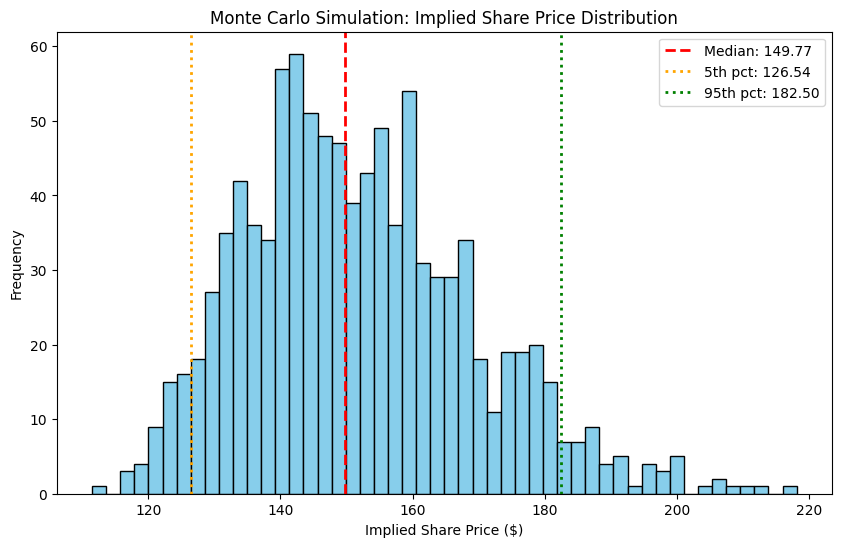

Median Share Price: $149.77
5th Percentile: $126.54
95th Percentile: $182.50


In [ ]:
import scipy.stats as stats

def monte_carlo_dcf(
    model,
    n_sim=1000,
    wacc_mu=0.08, wacc_sigma=0.005,
    perp_g_min=0.01, perp_g_mode=0.02, perp_g_max=0.03,
    earn_g_min=0.03, earn_g_mode=0.05, earn_g_max=0.07,
    capex_g_min=0.01, capex_g_mode=0.03, capex_g_max=0.05,
    wc_mu=0.7, wc_sigma=0.1,
    random_seed=42
):
    np.random.seed(random_seed)
    results = []
    original_beta = model.beta
    original_erp = model.erp

    for _ in range(n_sim):
        # --- Modified: Sample beta, set model.beta, recalc wacc ---
        sampled_beta = max(np.random.normal(loc=original_beta, scale=wacc_sigma / original_erp), 0.01)
        model.beta = sampled_beta
        model.erp = original_erp
        wacc = model._wacc()
        perp_g = stats.triang.rvs(
            (perp_g_mode - perp_g_min) / (perp_g_max - perp_g_min),
            loc=perp_g_min, scale=perp_g_max - perp_g_min
        )
        earn_g = stats.triang.rvs(
            (earn_g_mode - earn_g_min) / (earn_g_max - earn_g_min),
            loc=earn_g_min, scale=earn_g_max - earn_g_min
        )
        capex_g = stats.triang.rvs(
            (capex_g_mode - capex_g_min) / (capex_g_max - capex_g_min),
            loc=capex_g_min, scale=capex_g_max - capex_g_min
        )
        wc_adj = np.random.normal(wc_mu, wc_sigma)

        # DCF calculation (same logic as run_dcf, but with sampled params)
        ebit = float(model.inc['ebitda'][0]) - float(model.inc['depreciationAndAmortization'][0])
        depr = float(model.cf['depreciationAndAmortization'][0])
        wc = float(model.cf['changeInWorkingCapital'][0])
        capex = float(model.cf['capitalExpenditure'][0])
        fcf = ebit * (1 - model.tax_rate) + depr + wc + capex
        npv_fcf = [fcf]
        for yr in range(1, model.years + 1):
            ebit *= (1 + earn_g)
            depr *= (1 + earn_g)
            capex *= (1 + capex_g)
            wc *= wc_adj
            fcf = ebit * (1 - model.tax_rate) + depr + wc + capex
            npv = fcf / ((1 + wacc) ** yr)
            npv_fcf.append(npv)
        terminal_fcf = npv_fcf[-1] * (1 + perp_g)
        terminal_value = terminal_fcf / (wacc - perp_g)
        npv_terminal = terminal_value / ((1 + wacc) ** (model.years + 1))
        enterprise_value = sum(npv_fcf) + npv_terminal
        equity_value = enterprise_value - model.debt + model.cash
        share_price = equity_value / model.shares
        results.append(share_price)

    # Restore model.beta and model.erp
    model.beta = original_beta
    model.erp = original_erp

    results = np.array(results)
    # Display results
    plt.figure(figsize=(10,6))
    plt.hist(results, bins=50, color='skyblue', edgecolor='k')
    plt.title('Monte Carlo Simulation: Implied Share Price Distribution')
    plt.xlabel('Implied Share Price ($)')
    plt.ylabel('Frequency')
    plt.axvline(np.median(results), color='red', linestyle='dashed', linewidth=2, label=f"Median: {np.median(results):.2f}")
    plt.axvline(np.percentile(results, 5), color='orange', linestyle='dotted', linewidth=2, label=f"5th pct: {np.percentile(results,5):.2f}")
    plt.axvline(np.percentile(results, 95), color='green', linestyle='dotted', linewidth=2, label=f"95th pct: {np.percentile(results,95):.2f}")
    plt.legend()
    plt.show()

    print(f"Median Share Price: ${np.median(results):.2f}")
    print(f"5th Percentile: ${np.percentile(results,5):.2f}")
    print(f"95th Percentile: ${np.percentile(results,95):.2f}")

# Usage example:
monte_carlo_dcf(dcf_model)